In [1]:
import math
class value :
    def __init__(self,value, _children=(),_op='',label=''):
        self.data = value
        self._op = _op
        self.grad = 0.0
        self.label = label
        self._prev = set(_children)
        
        
        self._backward = lambda: None
        
    def __repr__(self):
        return f"Value(data={self.data})"
    
    def __add__(self,other):
        other = other if isinstance(other,value) else value(other)
        out = value(self.data + other.data,(self,other),'+')
        def _backward():
            self.grad += 1.0 * out.grad
            other.grad += 1.0* out.grad
        out._backward = _backward
        return out
    
    def __radd__(self,other):
        return self+other
    
    def __mul__(self,other):
        other = other if isinstance(other,value) else value(other)
        out = value(self.data* other.data , (self,other),'*')
        def _backward():
            self.grad += out.grad * other.data
            other.grad += out.grad * self.data
        out._backward = _backward
        return out
    
    def __rmul__(self,other):
        return self*other
    
    def __pow__(self, other):
        assert isinstance(other, (int, float))
        out = value(self.data**other, (self,), f'**{other}')

        def _backward():
            self.grad += other * (self.data ** (other - 1)) * out.grad
        out._backward = _backward

        return out
    
    def __truediv__(self, other): # self / other
        other = other if isinstance(other,value) else value(other)
        return self * other**-1
    
    def tanh(self):
        x = self.data
        exp = math.exp(2*x)
        t = (exp - 1)/(exp + 1)
        out = value(t, (self, ), 'tanh')

        def _backward():
          self.grad += (1 - t**2) * out.grad
        out._backward = _backward
        return out
    
    def backward(self):
    
        topo = []
        visited = set()
        def build_topo(v):
          if v not in visited:
            visited.add(v)
            for child in v._prev:
              build_topo(child)
            topo.append(v)
        build_topo(self)

        self.grad = 1.0
        for node in reversed(topo):
          node._backward()

In [2]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': 'LR'}) # LR = left to right
  
  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    # for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)

  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

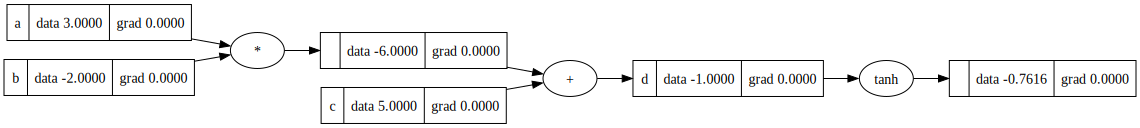

In [3]:
a = value(3,label='a')
b = value(-2,label='b')
c = value(5,label='c')

d = a*b + c
d.label = 'd'
e=d.tanh()
draw_dot(e)

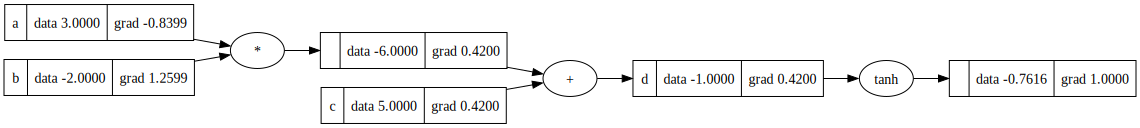

In [4]:
e.backward()
draw_dot(e)

In [5]:
a.data= a.data + 0.1
d = a*b + c
e=d.tanh()
e.data

-0.8336546070121553

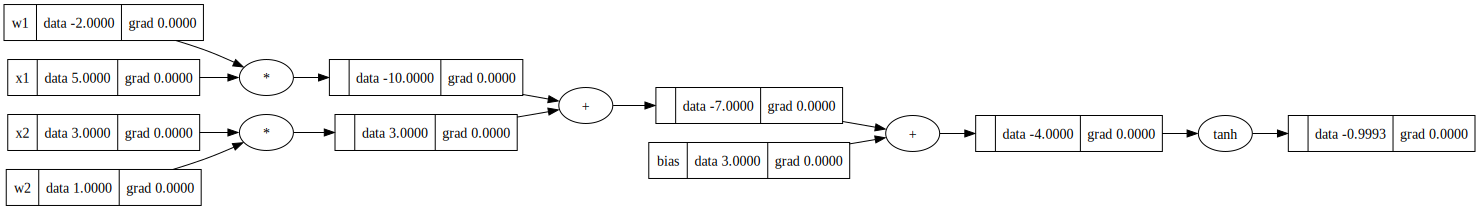

In [6]:
# one neuron
#x1 ,x2 are inputs
x1 = value(5,label='x1');x2 = value(3,label='x2')
#w1 , w2 are weights
w1 = value(-2,label='w1');w2 = value(1,label='w2')
bias = value(3,label='bias')
temp = x1*w1 + x2*w2 + bias
#activation
neuron = temp.tanh()
draw_dot(neuron)

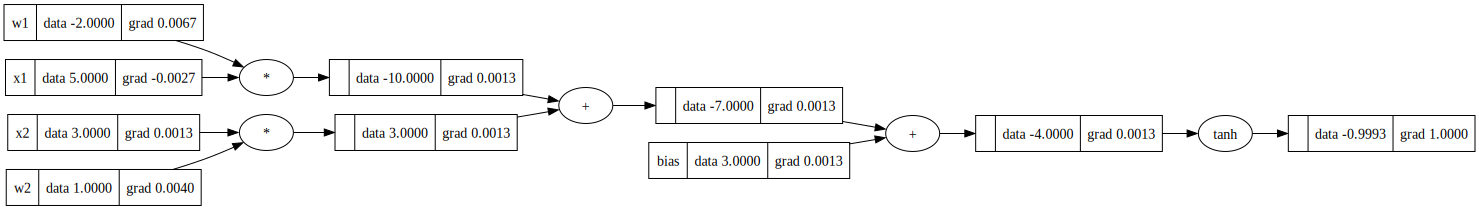

In [7]:
neuron.backward()
draw_dot(neuron)

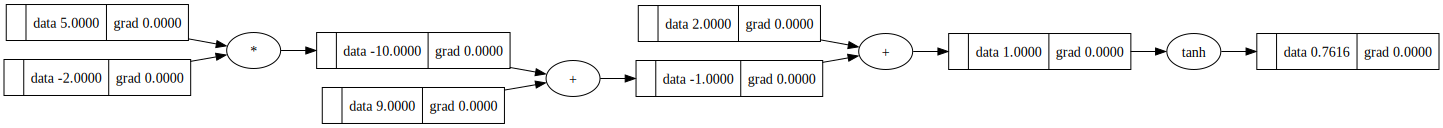

In [8]:
w1=5;w2=3
x1=value(-2);x2=3
b=2
temp = x1*w1 + x2 * w2 +b
neuron = temp.tanh()
draw_dot(neuron)

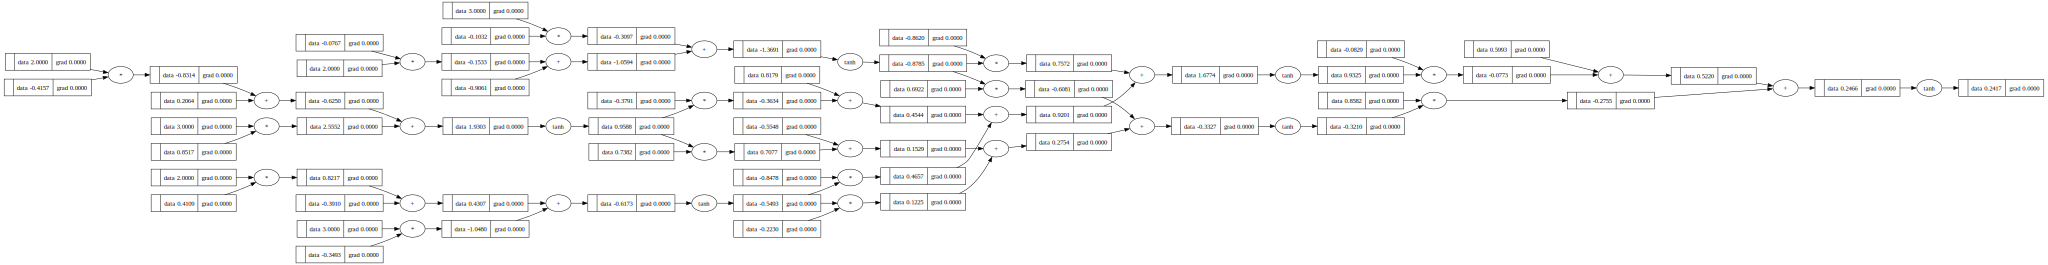

In [9]:
import random
class Neuron:
    def __init__(self,min):
        self.w = [value(random.uniform(-1,1)) for _ in range(min)]
        self.b = value(random.uniform(-1,1))
    
    def __call__(self , other):
        act = sum((wi*xi for wi , xi in zip(self.w,other)),self.b)
        out = act.tanh()
        return out
    
class Layer:
    def __init__(self,nin,nout):
        self.neurons =  [Neuron(nin) for _ in range(nout)]
        
    def __call__(self,x):
        outs = [n(x) for n in self.neurons]
        return outs[0] if len(outs) == 1 else outs
    
class MLP:
    def __init__(self, nin, nouts):
        sz = [nin] + nouts
        self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]
        
    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

'''defining MLP using Layer class '''
a = Layer(2,3) #Layer with 3 neurons
b = Layer(3,2)
c= Layer(2,1)
o=c(b(a([2,3]))) #connecting each Layers and forward passing inputs 2,3
draw_dot(o)

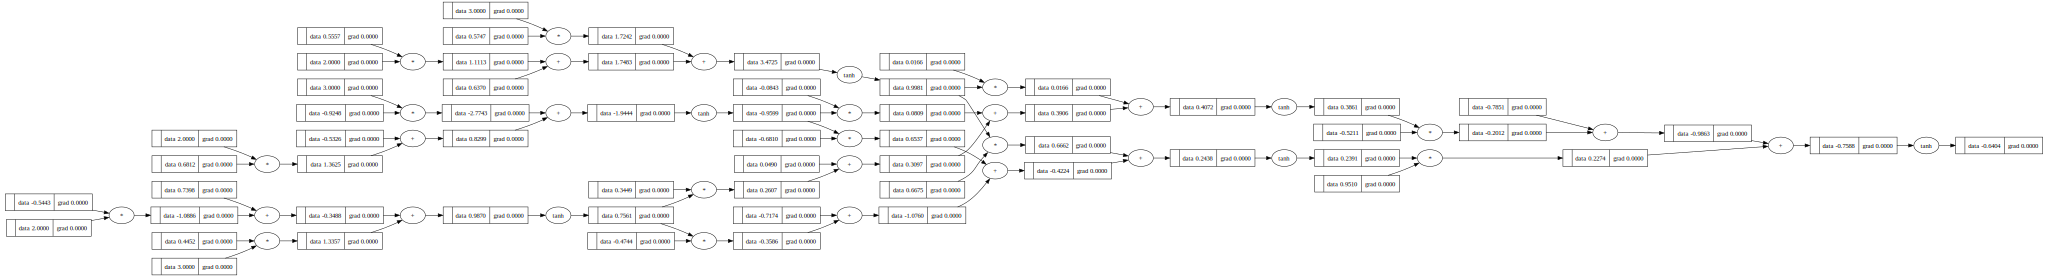

In [10]:
'''Definging MLP using MLP class'''
o = MLP(2,[3,2,1])
out = o([2,3])
draw_dot(out)